Start: x=5.49, y=0.53, f(x,y)=1.28
Koniec: x=5.44, y=0.28, f(x,y)=1.00


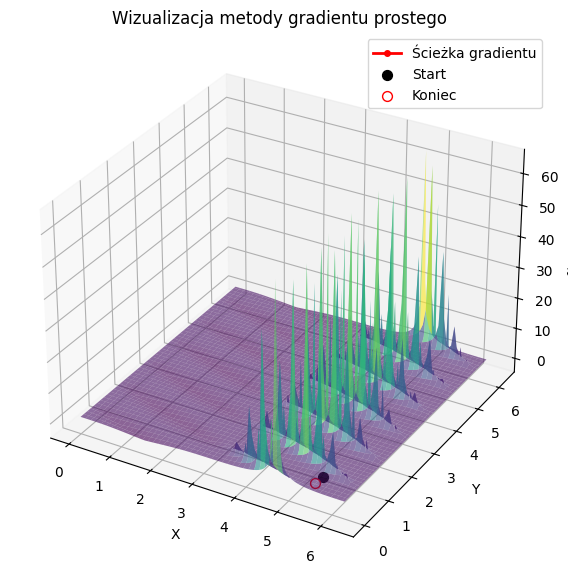

In [1]:
#Zadanie 1
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definicja funkcji celu
def target_fn(x, y):
    # tf.abs, aby uniknąć liczb zespolonych (NaN) gdy cos < 0
    return tf.pow(tf.abs(tf.cos(x + 3*y)), tf.sin(x))

# Inicjalizacja zmiennych (losowo w zakresie 0 do 2pi)
x = tf.Variable(np.random.uniform(0, 2*np.pi), dtype=tf.float32)
y = tf.Variable(np.random.uniform(0, 2*np.pi), dtype=tf.float32)

# Parametry optymalizatora
# Learning rate może wymagać dostrojenia w zależności od punktu startowego
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

# Listy do przechowywania historii (do wykresu)
x_history, y_history, z_history = [], [], []

# Pętla optymalizacyjna
steps = 50
print(f"Start: x={x.numpy():.2f}, y={y.numpy():.2f}, f(x,y)={target_fn(x,y).numpy():.2f}")

for i in range(steps):
    with tf.GradientTape() as tape:
        tape.watch([x, y])
        z = target_fn(x, y)
    
    # Zapisz historię
    x_history.append(x.numpy())
    y_history.append(y.numpy())
    z_history.append(z.numpy())
    
    # Oblicz gradienty
    gradients = tape.gradient(z, [x, y])
    
    # Zastosuj gradienty (krok w dół)
    opt.apply_gradients(zip(gradients, [x, y]))

print(f"Koniec: x={x.numpy():.2f}, y={y.numpy():.2f}, f(x,y)={target_fn(x,y).numpy():.2f}")

# 5. Wizualizacja 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Siatka punktów do wykresu powierzchni
X_val = np.linspace(0, 2*np.pi, 100)
Y_val = np.linspace(0, 2*np.pi, 100)
X_grid, Y_grid = np.meshgrid(X_val, Y_val)
# Obliczanie wartości Z dla siatki (numpy)
Z_grid = np.power(np.abs(np.cos(X_grid + 3*Y_grid)), np.sin(X_grid))

# Rysowanie powierzchni
ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.6)

# Rysowanie ścieżki optymalizacji
ax.plot(x_history, y_history, z_history, color='red', marker='o', markersize=4, linewidth=2, label='Ścieżka gradientu')
ax.scatter(x_history[0], y_history[0], z_history[0], color='black', s=50, label='Start')
ax.scatter(x_history[-1], y_history[-1], z_history[-1], color='white', s=50, edgecolors='red', label='Koniec')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')
ax.set_title('Wizualizacja metody gradientu prostego')
plt.legend()
plt.show()

In [2]:
#Zadanie 2
import numpy as np

# Definicja architektury 
nn_architecture = [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "relu"}
]

# Funkcje pomocnicze (Inicjalizacja i Aktywacje)
def init_layers(nn_architecture, seed=99):
    np.random.seed(seed)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

# Forward Propagation (zwraca cache potrzebny do gradientów)
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

# Backward Propagation (Obliczenie gradientów)
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = relu_backward
    elif activation == "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    # Pochodna funkcji kosztu (zakładamy MSE lub Binary Cross Entropy)
    # dL/dA_final
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values


# Przykładowe dane wejściowe (batch size = 3)
X_dummy = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]]) # 2 cechy, 3 próbki
Y_dummy = np.array([[0, 1, 0]]) # Oczekiwane wyjście

#  Inicjalizacja
params = init_layers(nn_architecture)

# Przejście w przód (Forward pass)
Y_hat, cache = full_forward_propagation(X_dummy, params, nn_architecture)

# Obliczenie gradientów (Backward pass)
gradients = full_backward_propagation(Y_hat, Y_dummy, cache, params, nn_architecture)

print("Obliczone gradienty:")
for key, value in gradients.items():
    print(f"{key}:\n{value}\n")

Obliczone gradienty:
dW2:
[[-2.08396734 -2.06470026]]

db2:
[[-3.99897745]]

dW1:
[[-0.01507313 -0.03768269]
 [-0.01649102 -0.04122803]]

db1:
[[-0.07536521]
 [-0.08245672]]

